# Practice changes analysis

Practice codes are the unique identifier used to track prescribing in the Practices Prescribing Data.

We assume that a practice code represents prescribing at a particular location.

This analysis compares `epraccur.csv` data from Feb 2016 and March 2017. The current data is made available [here](https://digital.nhs.uk/organisation-data-service/data-downloads/gp-data).



In [51]:
import pandas as pd
import numpy as np
headers = [
    'code','name','postcode','status_code','ccg','setting']
df1 = pd.read_csv("2016_02_epraccur.csv", names=headers, usecols=[0,1,9,12,23,25])
df2 = pd.read_csv("2017_03_epraccur.csv", names=headers, usecols=[0,1,9,12,23,25])
df1 = df1.set_index('code') 
df2 = df2.set_index('code')

First, we make a table that joins the data from both dates

In [52]:
joined = df1.join(df2, how='inner',  rsuffix='2017')
joined.head()



,name,postcode,status_code,ccg,setting,name2017,postcode2017,status_code2017,ccg2017,setting2017
code,,,,,,,,,,
A81001,THE DENSHAM SURGERY,TS18 1HU,A,00K,4,THE DENSHAM SURGERY,TS18 1HU,A,00K,4
A81002,QUEENS PARK MEDICAL CENTRE,TS18 2AW,A,00K,4,QUEENS PARK MEDICAL CENTRE,TS18 2AW,A,00K,4
A81003,VICTORIA MEDICAL PRACTICE,TS26 8DB,A,00K,4,VICTORIA MEDICAL PRACTICE,TS26 8DB,D,00K,4
A81004,WOODLANDS ROAD SURGERY,TS1 3BE,A,00M,4,WOODLANDS ROAD SURGERY,TS1 3BE,A,00M,4
A81005,SPRINGWOOD SURGERY,TS14 7DJ,A,00M,4,SPRINGWOOD SURGERY,TS14 7DJ,A,00M,4


Now let's focus on items whose status has changed from closed to something else

In [55]:
changed_from_closed = joined[(joined.status_code != joined.status_code2017) & (joined.status_code == 'C')]
print "%s practices went from closed to something else" % changed_from_closed.status_code.count()
#changed[(changed.setting != changed.setting2017) & (changed.status_code2017 != 'C') & ((changed.setting == 4)|(changed.setting2017 == 4))]

0 practices went from closed to something else


In [56]:
changed_from_dormant = joined[(joined.status_code != joined.status_code2017) & (joined.status_code == 'D')]
print "%s practices went from dormant to something else" % changed_from_dormant.status_code.count()
#changed[(changed.setting != changed.setting2017) & (changed.status_code2017 != 'C') & ((changed.setting == 4)|(changed.setting2017 == 4))]

321 practices went from dormant to something else


In [57]:
changed_from_dormant.head()

,name,postcode,status_code,ccg,setting,name2017,postcode2017,status_code2017,ccg2017,setting2017
code,,,,,,,,,,
A81069,RAINBOW SURGERY,TS10 4NW,D,00M,4,RAINBOW SURGERY,TS10 4NW,C,00M,4
A82011,HARTINGTON STREET MEDICAL PRACTICE,LA14 5SL,D,01H,4,HARTINGTON STREET MEDICAL PRACTICE,LA14 5SL,C,01H,4
A82619,NELSON STREET SURGERY,LA15 8AF,D,01H,4,NELSON STREET SURGERY,LA15 8AF,C,01H,4
A82635,GROSVENOR HOUSE SURGERY (W),CA1 1LB,D,01H,4,GROSVENOR HOUSE SURGERY (W),CA1 1LB,C,01H,4
A82641,GROSVENOR HOUSE SURGERY (F),CA1 1LB,D,01H,4,GROSVENOR HOUSE SURGERY (F),CA1 1LB,C,01H,4


In [58]:
# Looks like a lot of these seemed to change their names?

print "%s of these practices kept the same name" % changed_from_dormant[changed_from_dormant.name == changed_from_dormant.name2017].status_code.count()

321 of these practices kept the same name


In [59]:
changed_from_dormant.groupby('status_code2017').status_code2017.describe()

status_code2017        
A                count       2
                 unique      1
                 top         A
                 freq        2
C                count     319
                 unique      1
                 top         C
                 freq      319
Name: status_code2017, dtype: object

In [60]:
changed_from_dormant[changed_from_dormant.status_code2017 != 'C']

,name,postcode,status_code,ccg,setting,name2017,postcode2017,status_code2017,ccg2017,setting2017
code,,,,,,,,,,
Y02514,LITHERLAND PRIMARY CARE WALK-IN SERVICE,L21 9JN,D,01T,4,LITHERLAND PRIMARY CARE WALK-IN SERVICE,L21 9JN,A,01T,4
Y02823,DMC VICARAGE LANE,E15 4ES,D,08M,4,DMC VICARAGE LANE,E15 4ES,A,08M,4


In [12]:
dormant_in_2016_codes = tuple(df1[df1.status_code == 'D'].index)
sql = """SELECT
  month,
  practice,
  SUM(items) AS items
FROM
  `hscic.prescribing`
WHERE
  month >= TIMESTAMP('2016-02-01') AND practice IN %s
GROUP BY
  month,
  practice
ORDER BY
  month, practice""" % str(dormant_in_2016_codes)

prescribing = pd.read_gbq(sql, project_id='ebmdatalab', dialect='standard')


Requesting query... ok.
Query running...
Query done.
Processed: 18.4 Gb

Retrieving results...
Got 767 rows.

Total time taken 3.94 s.
Finished at 2017-07-25 15:59:08.


In [46]:
# Look at the mean / median number of months a dormant practice continues prescribing for
prescribing.groupby('practice').agg('count')['items'].describe()

count    194.000000
mean       3.953608
std        2.808741
min        1.000000
25%        2.000000
50%        3.000000
75%        6.000000
max       16.000000
Name: items, dtype: float64

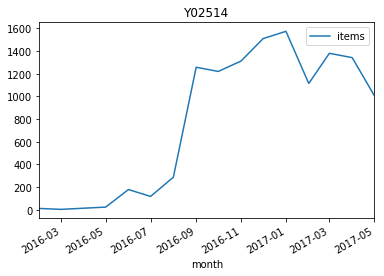

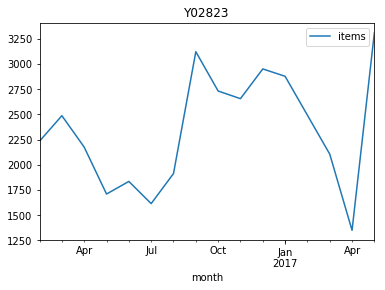

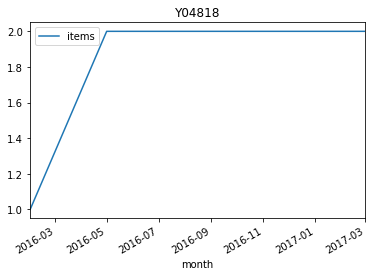

In [49]:
# How about the practices dormant in Feb 2016 which were prescribing in Feb 2017?
%matplotlib inline
import matplotlib.pyplot as plt
for i, j in prescribing[prescribing.practice.isin(prescribing[prescribing.month > '2017-01-01'].practice)].groupby('practice'):
    j.set_index('month').plot(title=i)
    plt.show()

        
        
        
        
        

In [65]:
# Which still-dormant practices have had their CCG membership updated?
remained_dormant = joined[(joined.status_code == joined.status_code2017) & (joined.status_code == 'D') & (joined.ccg != joined.ccg2017)]
print len(remained_dormant)

0


In [66]:
# As a check - which have had CCG changes?
joined[(joined.ccg != joined.ccg2017)]
# Note: only one is a standard GP (setting = 4)

,name,postcode,status_code,ccg,setting,name2017,postcode2017,status_code2017,ccg2017,setting2017
code,,,,,,,,,,
A81632,LAWSON STREET PRACTICE,TS18 1HU,A,114,4,LAWSON STREET PRACTICE,TS18 1HU,A,00K,4
W00150,KALEIDOSCOPE CARDIFF,CF10 2FE,A,7A5,0,KALEIDOSCOPE CARDIFF,CF10 2FE,A,7A4,0
W00151,KALEIDOSCOPE BARRY,CF63 4HD,A,7A5,0,KALEIDOSCOPE BARRY,CF63 4HD,A,7A4,0
Y00623,WESTCALL OOH,RG41 2RE,A,11D,2,WESTCALL OOH,RG40 1XJ,A,RWX,2
Y00922,B.D.I.P.PEARL,B8 2HB,A,13P,8,B.D.I.P.PEARL,B8 2HB,A,04X,8
Y01709,DONCASTER DRUG & ALCOHOL SERVICES,DN1 2EZ,A,205,8,DONCASTER DRUG & ALCOHOL SERVICES,DN1 2EZ,A,RXE,8
Y02139,CHILDRENS CENTRE,NR4 7PA,A,06W,9,CHILDRENS CENTRE,NR4 7PA,A,RY3,9
Y02548,LPS PEARL MEDICAL CENTRE,B8 2HB,A,13P,0,LPS PEARL MEDICAL CENTRE,B8 2HB,A,04X,0
Y02758,BEACON HEALTH,PO30 5TG,A,10L,1,URGENT CARE,PO30 5TG,A,R1F,1
